In [36]:
import h5py
import numpy as np
import glob 
import os
import matplotlib.pyplot as plt
import pandas as pd
datadir = '/nfsscratch/Users/wndrsn/atl02'

# Noisy Night Time Data

Text(0.5, 1.0, 'Simulated Noisy Image')

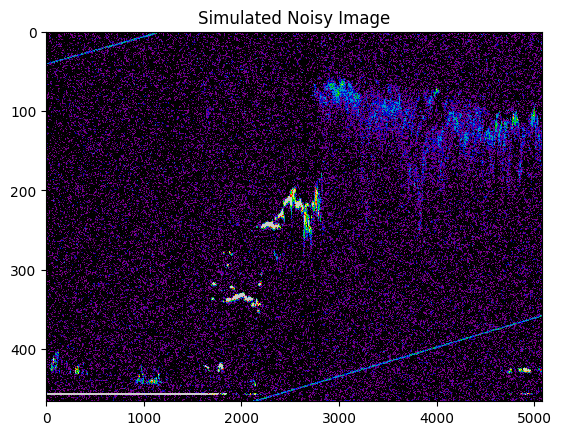

In [37]:
def get_atm_bins_mybackg(file):
    with h5py.File(file, 'r') as data:
        atm = {k: np.array(data[f'/atlas/pce1/atmosphere_s/{k}']) for k in data['/atlas/pce1/atmosphere_s'].keys()}
        atm_bins = atm['atm_bins']
        n_records = atm_bins.shape[0]
        bg = atm_bins.mean(axis=1, keepdims=True)
        atm_bins_mybackg = atm_bins-bg
        return atm_bins_mybackg
    
def getBinsloud(file):
    with h5py.File(file, 'r') as data:
        atm = {k: np.array(data[f'/atlas/pce1/atmosphere_s/{k}']) for k in data['/atlas/pce1/atmosphere_s'].keys()}
        atm_bins = atm['atm_bins']
        n_records = atm_bins.shape[0]
        bg = atm_bins.mean(axis=1, keepdims=True)
        atm_bins_mybackg = atm_bins-bg
        # return atm_bins,bg,atm_bins_mybackg
        # return atm_bins_mybackg
        return atm_bins
    
def make_noisy(df,noise_level):
    noise_level = noise_level*100
    noisy_bg = np.full_like(df, noise_level)

    noisy_dataset = df + noisy_bg

    noisy = np.random.poisson(np.maximum(noisy_dataset, 0))

    bgN = noisy.mean(axis=1, keepdims=True)

    atm_bins_mybackg = noisy - bgN
    
    return atm_bins_mybackg

# First subplot
datadir = '/nfsscratch/Users/wndrsn/atl02'
files = sorted(glob.glob(os.path.join(datadir, f'**/*.h5'), recursive=True))[2]
raw_night_dataset = getBinsloud(files) 
night_dataset = make_noisy(get_atm_bins_mybackg(files),4) 
plt.imshow(night_dataset.T, aspect='auto', cmap='nipy_spectral', vmin=0, vmax=50)
plt.title('Simulated Noisy Image')

# Day Time Data

-854.2912205567452 5615.089935760171 -8.283710927010696e-17


Text(0.5, 1.0, 'Day Time Data With Background Subtraction')

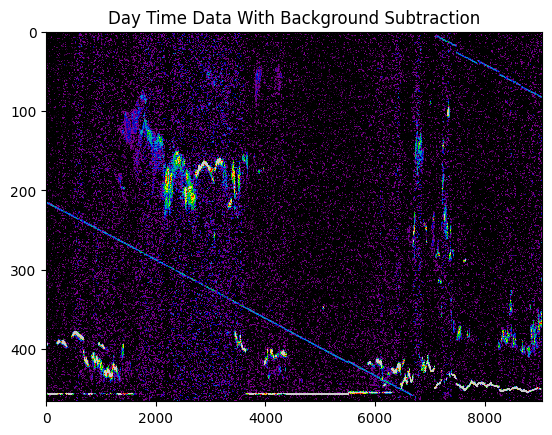

In [38]:
savedir = '/nfsscratch/Users/wndrsn/atl02'  # Replace with the actual save directory path
file = sorted(glob.glob(os.path.join(datadir, f'**/*.h5'), recursive=True))[90]
raw_solar_dataset = getBinsloud(file)
solar_dataset = get_atm_bins_mybackg(file) 
print(solar_dataset.min(),solar_dataset.max(),solar_dataset.mean())
plt.imshow(solar_dataset.T, aspect='auto', cmap='nipy_spectral', vmin=0, vmax=50)
plt.title('Day Time Data With Background Subtraction')

# Difference in scale seems to be causing issues with learning algorithm
- Night time data is exponentially less loud
- Algorithm keeps generating negative psnr values
- Current results only denoise created data
- Algorithm is not aggressive enough as a result and does not work with real data

In [39]:
summary_df = pd.DataFrame({
    'Dataset': ['Raw Night','Raw Day','Noisy Night-bg', 'Solar-bg','X larger'],
    'Min': [raw_night_dataset.min(), raw_solar_dataset.min(),night_dataset.min(),solar_dataset.min(),solar_dataset.min()/night_dataset.min()],
    'Max': [raw_night_dataset.max(), raw_solar_dataset.max(),night_dataset.max(),solar_dataset.max(),solar_dataset.max()/night_dataset.max()],
    'Mean': [raw_night_dataset.mean(), raw_solar_dataset.mean(),night_dataset.mean(),solar_dataset.mean(),solar_dataset.mean()/night_dataset.mean()]
    
})
display(summary_df)

,Dataset,Min,Max,Mean
0,Raw Night,0.000000,1433.000000,1.806069e+00
1,Raw Day,48.000000,5885.000000,5.008393e+02
2,Noisy Night-bg,-100.293362,1447.119914,1.037978e-16
3,Solar-bg,-854.291221,5615.089936,-8.283711e-17
4,X larger,8.517924,3.880183,-7.980625e-01


# Scaling issues can be fixed using multiplication before feeding into algorithm
- Currently looking further into this, however it does not seem to fix the issue of the rho0 value being too small to be effective

min = -138.83297644539618 max = 5757.616702355461 mean = 5.40170140618648e-16


Text(0.5, 1.0, 'Simulated Noisy Image With Scaling')

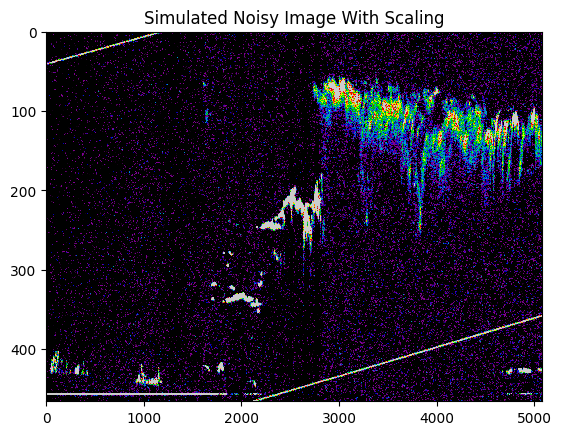

In [40]:
import os
import glob
import matplotlib.pyplot as plt

import numpy as np


# First subplot
datadir = '/nfsscratch/Users/wndrsn/atl02'
files = sorted(glob.glob(os.path.join(datadir, f'**/*.h5'), recursive=True))[2]
dataset = make_noisy(get_atm_bins_mybackg(files)*4, 8)

print('min =',dataset.min(),'max =',dataset.max(),'mean =',dataset.mean())
plt.imshow(dataset.T, aspect='auto', cmap='nipy_spectral', vmin=0, vmax=50)
plt.title('Simulated Noisy Image With Scaling')   

# Distribution of data after background subtraction leads to "negative" photon counts
- Negative photon counts are impossible, therefore we can assume it is background
- Selecting the values < 1 confirms it is mostly background
- Objects we are looking for are not selected

Text(0.5, 1.0, 'Negative Value Mask')

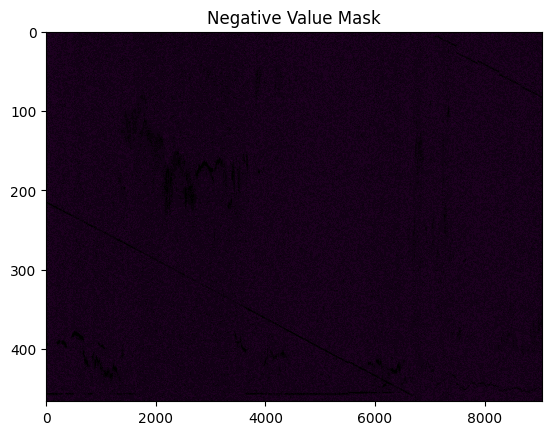

In [41]:
solar_dataset_filter1 = solar_dataset < 1 

plt.imshow(solar_dataset_filter1.T, aspect='auto', cmap='nipy_spectral', vmin=0, vmax=50)
plt.title('Negative Value Mask')

# Selecting the values > 1 seems to select mainly the objects we want to focus on

Text(0.5, 1.0, 'Positive Value Mask')

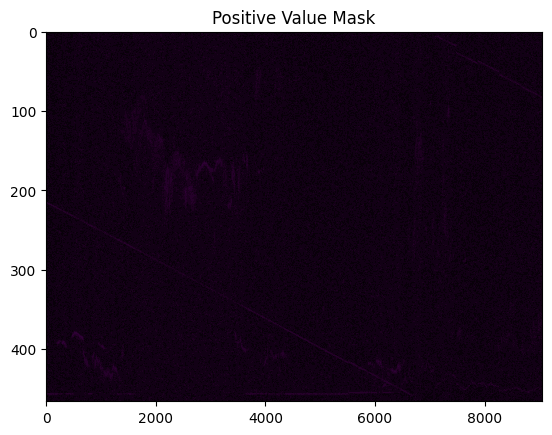

In [42]:
solar_dataset_filter2 = solar_dataset > 1
plt.imshow(solar_dataset_filter2.T, aspect='auto', cmap='nipy_spectral', vmin=0, vmax=50)
plt.title('Positive Value Mask')

# Use Background Substract with negative value mask

-862.3213948469389 5607.059761469977 -8.03017429019377


Text(0.5, 1.0, 'Day Time Data + Negative Value Mask')

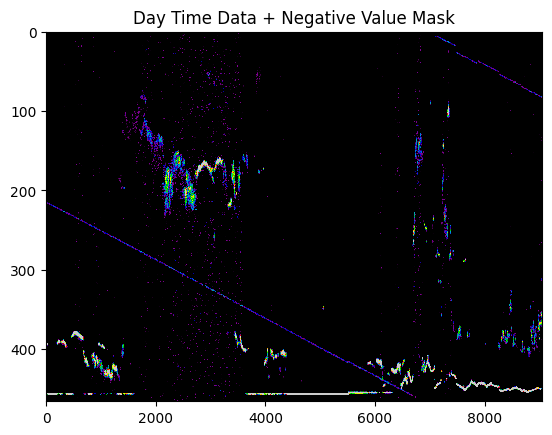

In [43]:
newset = solar_dataset + solar_dataset[solar_dataset_filter1].mean()/2
print(newset.min(),newset.max(),newset.mean())
# # plt.hist(dataset)
plt.imshow(newset.T, aspect='auto', cmap='nipy_spectral', vmin=0, vmax=50)
plt.title('Day Time Data + Negative Value Mask')

- Why does this clear up the image but hardly effect the distribution of the data? 
- How can we reset the index to be only positive values? 

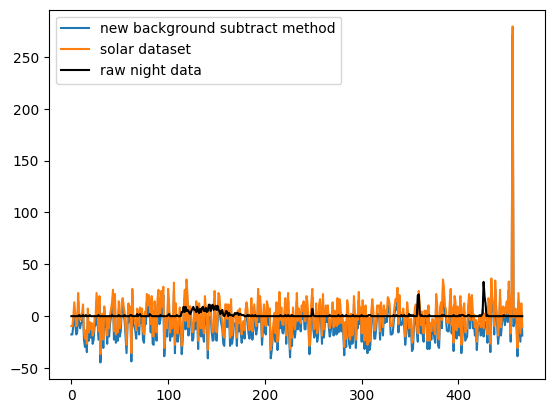

In [44]:
plt.plot(newset[6000], label='new background subtract method')
plt.plot(solar_dataset[6000], label='solar dataset')
plt.plot(raw_night_dataset[5079], label='raw night data',color = 'black')

plt.legend(loc='best')